## Human In The Loop - Approval workflows

### Pause execution for Human Approval

### Protect User with PII Gaurdrail

The guardrail node detects and blocks the following PII Types:
- **SSN**: Social Security Networks
- **Credit Card**: Card Numbers
- **Mobile Number**: Phone Numbers
- **Email**: Email addresses
- **URL/link**: Web links

### Use Cases:
1. Financial Systems 
2. Content Moderation
3. Customer Support 
4. DevOps

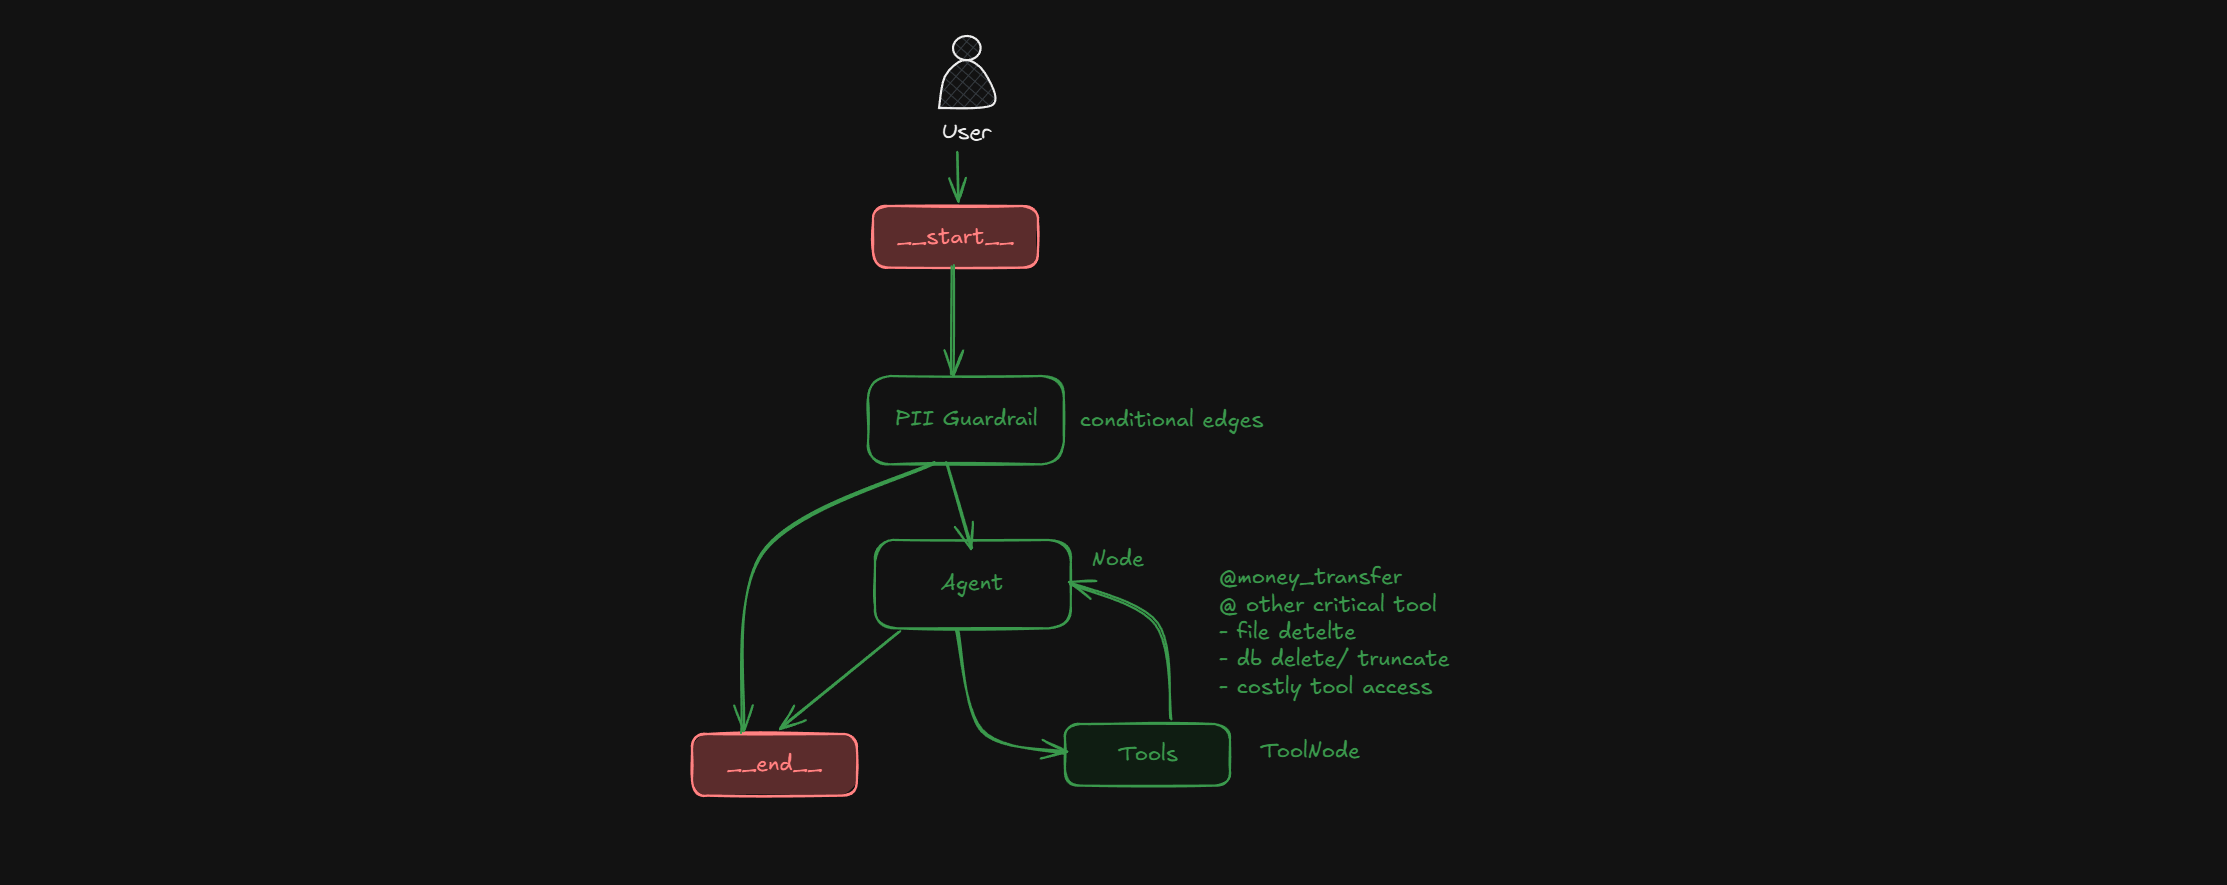

### For HITL it is important to have, some sort of memory saver

In [100]:
# Imports
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict, Annotated
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.types import Command, interrupt
from dotenv import load_dotenv

import os
import re

# CONFIGURATION
BASE_URL="https://api.groq.com/openai/v1"
MODEL_NAME="openai/gpt-oss-20b"
API_KEY = os.getenv("GROQ_API_KEY")
llm = ChatOpenAI(model=MODEL_NAME, base_url=BASE_URL, api_key=API_KEY)

In [101]:
# Defining state
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

### In the below tool, we have written an interrupt for our, `transfer_money` function, the interrupt is conditional, if the amount is above 1000 Rupees then it throws an error, The Error is reflected in the StateGraph where, it causes to create an interrupt or stop the flow for Human Input and goes further conditionally based on the provided Human Input

In [102]:
# Transfer Money Tool (Dummy Tool)
@tool
def transfer_money(amount:int, recipient:str):
    """
    Transfer money. Large transfers require approval.

    Args:
        amount: Amount in dollars
        recipient: Recipient name
    """

    # let's ask user approval if money is more than 1000
    if amount > 1000:
        approval = interrupt(
            {
                "type": "approval_required",
                "amount": amount,
                "recipient": recipient
            }
        )

        if approval.get("decision") != "approve":
            return "Transfer is cancelled!"

    return f"Transferred {amount} to {recipient}"

In [103]:
transfer_money.invoke({"amount": 100, "recipient": "Manmath Tiwari"})

'Transferred 100 to Manmath Tiwari'

### Guardrail Node - PII Detection

In [104]:
patterns = {
        "SSN": r'\b\d{3}-\d{2}-\d{4}\b',  # SSN: 123-45-6789
        "Credit Card": r'\b\d{4}[\s-]?\d{4}[\s-]?\d{4}[\s-]?\d{4}\b',  # Credit Card: 1234-5678-9012-3456
        "Mobile Number": r'\b(\+?\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}\b',  # Mobile: +1-234-567-8900
        "Email": r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',  # Email: user@example.com
        "URL/Link": r'https?://[^\s]+|www\.[^\s]+'  # URL: http://example.com or www.example.com
    }

def guardrail_node(state: AgentState):
    last_message = state['messages'][-1].content

    for pii_types, pattern in patterns.items():
        if re.search(pattern, last_message):
            return {'messages': [SystemMessage(f"Request Blocked. {pii_types} contains sensitive information")]}
    
    return {'messages': []}

In [105]:
# Agent Node
def agent_node(state: AgentState):
    tools = [transfer_money]
    llm_with_tools = llm.bind_tools(tools)
    system_prompt = SystemMessage("You are a financial helping agent, use transfer_money tool when required")
    messages = state['messages'] + [system_prompt]
    response = llm_with_tools.invoke(messages)
    if hasattr(response, "tool_calls") and response.tool_calls:
        for tc in response.tool_calls:
            print(f"[AGENT] called tool {tc.get('name', '?')} with args {tc.get('args', '?')}")
    else:
        print(f"[AGENT] is responding...")
    return {'messages': [response]}

In [106]:
# Conditional Edges -> Agent Node, Guardrail

# 1: Agent-Tool Router
def should_continue(state: AgentState):
    last = state['messages'][-1]
    if hasattr(last, "tool_calss") and last.tool_calls:
        return "tool_node"
    else:
        return END

# 2: Guardrail-router
def guardrail_router(state: AgentState):
    last = state['messages'][-1]
    if isinstance(last, SystemMessage):
        last.pretty_print()
        return END
    return "agent_node"

In [107]:
# DB Setup
# import os
# db_name="db/checkpointers.db"
# import sqlite3
# os.makedirs('db', exist_ok=True)

# conn = sqlite3.connect(db_name, check_same_thread=False)
# checkpointer = SqliteSaver(conn)

### To make keep connection fresh, always keep connection inside of `create_agent()` function

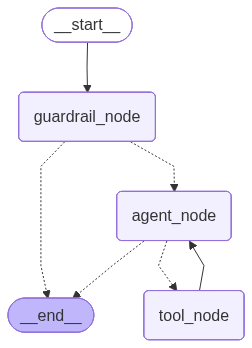

In [108]:
# Orchestration
import os
db_name="db/checkpointers.db"
import sqlite3
os.makedirs('db', exist_ok=True)

def create_agent():
    builder = StateGraph(AgentState)

    conn = sqlite3.connect(db_name, check_same_thread=False)
    checkpointer = SqliteSaver(conn)

    builder.add_node("guardrail_node", guardrail_node)
    builder.add_node("agent_node", agent_node)
    builder.add_node("tool_node", ToolNode([transfer_money]))

    builder.add_edge(START, "guardrail_node")
    builder.add_conditional_edges("guardrail_node", guardrail_router, ["agent_node", END])
    builder.add_conditional_edges("agent_node", should_continue, ["tool_node", END])
    builder.add_edge("tool_node", "agent_node")

    graph = builder.compile(checkpointer)
    return graph

agent = create_agent()
agent

In [109]:
config = {"configurable": {"thread_id":"demo-1"}}
query = "Transfer 10000 to Manmath"
result = agent.invoke({
    "messages": [HumanMessage(query)]
}, config=config)
result

[AGENT] is responding...


{'messages': [HumanMessage(content='Transfer 500 to Manmath', additional_kwargs={}, response_metadata={}, id='47b0e951-b541-48c5-8133-0eb1c9b5b72a'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 166, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 42, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.051372045, 'prompt_time': 0.008206242, 'completion_time': 0.072770584, 'total_time': 0.080976826}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'id': 'chatcmpl-e125611e-b3e4-4219-83e7-03cd1da7e6b5', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c1dda-fbed-75d2-bad1-1ab4bcbcd3df-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 500, 'recipient': 'Manmath'}, 'id': 'fc_89a

In [110]:
agent.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Transfer 500 to Manmath', additional_kwargs={}, response_metadata={}, id='47b0e951-b541-48c5-8133-0eb1c9b5b72a'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 166, 'total_tokens': 236, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 42, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': None, 'queue_time': 0.051372045, 'prompt_time': 0.008206242, 'completion_time': 0.072770584, 'total_time': 0.080976826}, 'model_provider': 'openai', 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_80501ff3a1', 'id': 'chatcmpl-e125611e-b3e4-4219-83e7-03cd1da7e6b5', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c1dda-fbed-75d2-bad1-1ab4bcbcd3df-0', tool_calls=[{'name': 'transfer_money', 'args': {'amount': 500, 'recipient': 'Manma

In [111]:
if isinstance(result, Command) and result.is_interrupt:
    interrupt_payload = result.payload
    decision = input("Approve transfer? (approve/reject): ")
    agent.invoke(
    Command.resume({"decision": decision}),
    config=config
)